In [1]:
from scipy.special import logsumexp
from autograd import numpy as np
from autograd import scipy as sp
from autograd import grad
from autograd.misc.optimizers import adam, sgd
import autograd.scipy.stats.norm as norm
from autograd.scipy.stats import multivariate_normal
import numpy
import math
import pdb
from nn_models import Feedforward
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import sys

ModuleNotFoundError: No module named 'nn_models'

In [2]:
class VAE:
    def __init__(self, decoder_architecture, encoder_architecture, x_var, random=None, decoder_weights=None, encoder_weights=None):
        '''constructor'''
        self.x_dim = decoder_architecture['output_dim']
        self.z_dim = decoder_architecture['input_dim']

        self.x_var = x_var

        assert encoder_architecture['input_dim'] == self.x_dim
        assert encoder_architecture['output_dim'] == self.z_dim * 2

        self.decoder = Feedforward(decoder_architecture, random=random, weights=decoder_weights)
        self.encoder = Feedforward(encoder_architecture, random=random, weights=encoder_weights)

        self.objective_trace = np.empty((1, 1))
        self.param_trace = np.empty((1, self.decoder.D + self.encoder.D))
        self.S = 10

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)
            
    def generate(self, weights=None, N=100):
        '''use the generative model to generate x given zs sampled from the prior'''
        z_samples = self.random.normal(0, 1, size=(self.z_dim, N))

        if weights is None:
            x_samples = self.decoder.forward(self.decoder.weights, z_samples)
        else:
            x_samples = self.decoder.forward(weights, z_samples)
            
        return x_samples[0]

    def infer(self, x, weights=None):
        '''use the inference model to infer parameters of q(z|x)'''
        if weights is None:
            z = self.encoder.forward(self.encoder.weights, x)
        else:
            z = self.encoder.forward(weights, x)
            
        return z[0]
    
    def unpack_params(self, z_params):
        '''unpack variational parameters for q(z|x)'''
        assert len(z_params.shape) == 2
        assert z_params.shape[0] == 2 * self.z_dim

        mean, parametrized_var = z_params[:self.z_dim], z_params[self.z_dim:]
        std = np.exp(parametrized_var)

        return mean, std
    
    def unpack_weights(self, params):
        '''unpack the weights for the encoder and decoder'''
        assert len(params.shape) == 2
        assert params.shape[1] == self.encoder.D + self.decoder.D
        
        decoder_weights = params[:, :self.decoder.D].reshape((1, -1))
        encoder_weights = params[:, self.decoder.D:].reshape((1, -1))
        
        return encoder_weights, decoder_weights
    
    def make_objective(self, x_train, S):
        '''make variational objective function and gradient of the variational objective'''
        assert len(x_train.shape) == 2
        assert x_train.shape[0] == self.x_dim
        

        if S is not None:
            self.S = S

        N = x_train.shape[1]
        x_dummy = np.zeros((self.S, self.x_dim, N))

           
        def variational_objective(params, t):
            '''definition of the ELBO'''
            encoder_weights, decoder_weights = self.unpack_weights(params)

            #infer z's
            z_params = self.encoder.forward(encoder_weights, x_train)[0]
            
            #unpack var parameters
            mean, std = self.unpack_params(z_params)
            assert std.shape == (self.z_dim, N)
            assert mean.shape == (self.z_dim, N)
            
            #sample z's
            z_samples = np.random.normal(0, 1, size=(self.S, self.z_dim, N)) * std + mean
            assert z_samples.shape == (self.S, self.z_dim, N)
            
            #predict x's
            x = self.decoder.forward(decoder_weights, z_samples)
            assert x.shape == (self.S, self.x_dim, N)
            
            #evaluate log-likelihood
            log_likelihood = np.sum(norm.logpdf(x_train, x, self.x_var ** 0.5), axis=-2)
            assert log_likelihood.shape == (self.S, N)
                        
            #evaluate sampled z's under prior
            log_pz = np.sum(norm.logpdf(z_samples, 0.0, 1.0), axis=-2)
            assert log_pz.shape == (self.S, N)
            
            #evaluate sampled z's under variational distribution
            log_qz_given_x = np.sum(norm.logpdf(z_samples, mean, std), axis=-2)
            assert log_qz_given_x.shape == (self.S, N)
            
            #compute the elbo
            elbo = np.mean(log_likelihood - log_qz_given_x + log_pz)
            
            #return the negative elbo to be minimized
            return -elbo
            
            
        return variational_objective, grad(variational_objective)
    
                          
    def fit(self, x_train, S=None, params=None):
        '''minimize -ELBO'''
        assert x_train.shape[0] == self.x_dim

        ### make objective function for training
        objective, gradient = self.make_objective(x_train, S)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        param_init = self.random.normal(0, 0.3, size=(1, self.decoder.D + self.encoder.D))
        mass = None
        optimizer = 'adam'
        random_restarts = 1

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            check_point = params['check_point']
        if 'init' in params.keys():
            param_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(params, iteration, g):
            ''' Actions per optimization step '''
            objective_val = objective(params, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective_val))
            self.param_trace = np.vstack((self.param_trace, params))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective_val, np.linalg.norm(gradient(params, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_param = param_init

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(gradient, param_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[1:])
            
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[1:])
                opt_params = self.param_trace[1:][opt_index].reshape((1, -1))
                self.opt_params = opt_params
                encoder_weights, decoder_weights = self.unpack_weights(opt_params)
                self.decoder.weights = decoder_weights
                self.encoder.weights = encoder_weights
                optimal_obj = local_opt

            param_init = self.random.normal(0, 0.1, size=(1, self.decoder.D + self.encoder.D))

        self.objective_trace = self.objective_trace[1:]
        self.param_trace = self.param_trace[1:]

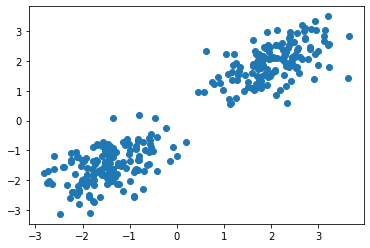

In [4]:
c_means = [[-1.5, -1.5], [2.0, 2.0]]
c_var = 0.30**2
x_var = 1e-2

indices = numpy.random.randint(2, size=300)
samples = [numpy.random.multivariate_normal(c_means[i], c_var * np.eye(2) + 0.2 * np.ones((2, 2))) + numpy.random.multivariate_normal(np.zeros(2), x_var**0.5 * np.eye(2)) for i in indices]

x_train = np.array(samples)
plt.scatter(x_train[:, 0], x_train[:, 1])
plt.show()

In [5]:
#decoder architecture
input_dim = 2
output_dim = 2
width = 50
hidden_layers = 1
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)
# activation_fn_type = 'linear'
# activation_fn = lambda x: x
decoder_architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': activation_fn_type,
                'activation_fn': activation_fn,
                'activation_fn_params': None}


#encoder architecture
input_dim = 2
output_dim = 4
width = 50
hidden_layers = 1
# activation_fn_type = 'relu'
# activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)



encoder_architecture = {'width': width,
                'hidden_layers': hidden_layers,
                'input_dim': input_dim,
                'output_dim': output_dim,
                'activation_fn_type': activation_fn_type,
                'activation_fn': activation_fn,
                'activation_fn_params': None}

vae = VAE(decoder_architecture, encoder_architecture, x_var)

In [6]:
# x_train, _ = generate_data(N=200, var=x_var) 

params = {'step_size':1e-2,
      'max_iteration':10000,
      'random_restarts':1,
     }


vae.fit(x_train.T, params=params, S=50)

Iteration 0 lower bound 451.18431563766785; gradient mag: 773.252146426361
Iteration 100 lower bound 4.908697628171715; gradient mag: 5.372971139207289
Iteration 200 lower bound 4.044120157078172; gradient mag: 3.0016720709495877
Iteration 300 lower bound 3.706721427213972; gradient mag: 1.511270906324021
Iteration 400 lower bound 3.5447078194996116; gradient mag: 2.2180427214495646
Iteration 500 lower bound 3.418117140767244; gradient mag: 2.7715563089940676
Iteration 600 lower bound 3.3042707459696827; gradient mag: 2.5043457902913766
Iteration 700 lower bound 3.2002100803927833; gradient mag: 3.4854206201833913
Iteration 800 lower bound 3.074797840880169; gradient mag: 3.218455151688598
Iteration 900 lower bound 2.9463161989617856; gradient mag: 7.312536285371847
Iteration 1000 lower bound 2.8564862996657254; gradient mag: 3.754592419514651
Iteration 1100 lower bound 2.8100873455047544; gradient mag: 6.177659029348194
Iteration 1200 lower bound 2.763823346038701; gradient mag: 1.759

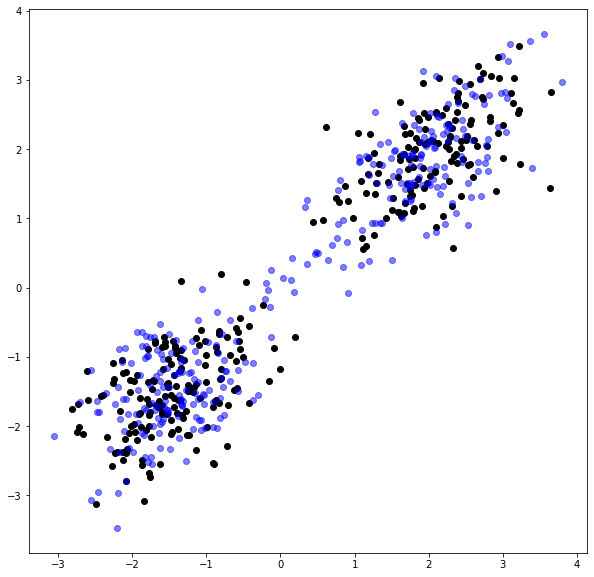

In [7]:
x_hat = vae.generate(N=300)
x_hat = x_hat + np.random.normal(0, x_var**0.5, size=x_hat.shape)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(x_train.T[0], x_train.T[1], color='black')
ax.scatter(x_hat[0], x_hat[1], color='blue', alpha=0.5)

plt.show()